In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
cudnn.benchmark = True
plt.ion()   # interactive mode

# Data transform


In [ ]:
data_transforms = {
    'train': transforms.Compose([
                        transforms.RandomResizedCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(
                            [0.485, 0.456, 0.406], 
                            [0.229, 0.224, 0.225]
                        )
    ]),
    'val': transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(
                            [0.485, 0.456, 0.406], 
                            [0.229, 0.224, 0.225]
                        )
    ]),
}

data_dir = '/content/drive/MyDrive/COURSES/CS331/FinalProject/dataset/GraphCXR/CXR_Reformat_Resize/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),  data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) 
                for x in ['train', 'val']}

class_names = image_datasets['train'].classes 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Show data

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


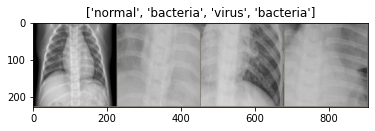

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Train model


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, save_log=False):
    history = {
        'all_epoch_info': []
    }
    train = {

    }
    val = {

    }
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'train':
                train = {
                    'loss': epoch_loss,
                    'acc': epoch_acc.item()
                }
            if phase == 'val':
                val = {
                    'loss': epoch_loss,
                    'acc': epoch_acc.item()
                }

            # deep copy the model
            if phase=='val':
                scheduler.step(epoch_loss)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), '/content/drive/MyDrive/COURSES/CS331/FinalProject/ResNet50.pt')

        history['all_epoch_info'].append({
            'epoch': epoch,
            'info': { 
                'train': train,
                'val': val
            }
        })
        # print(history)
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model if not save_log else model, history

# Visualize model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet50(pretrained=True)
cnt = 0
for param in model_ft.parameters():
    if cnt < 161 * 3 // 4:
        param.requires_grad = False
    else:
        break
    cnt += 1
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 3.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = ReduceLROnPlateau(optimizer_ft, 'min', factor=0.1, patience=3, min_lr=1e-6, verbose=True)

In [ ]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, scheduler=scheduler, num_epochs=50, save_log=True)

Epoch 1/50
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8181 Acc: 0.6389
val Loss: 0.5510 Acc: 0.7655

Epoch 2/50
----------
train Loss: 0.6504 Acc: 0.7183
val Loss: 0.5032 Acc: 0.7922

Epoch 3/50
----------
train Loss: 0.6133 Acc: 0.7391
val Loss: 0.5489 Acc: 0.7922

Epoch 4/50
----------
train Loss: 0.5862 Acc: 0.7491
val Loss: 0.5146 Acc: 0.7979

Epoch 5/50
----------
train Loss: 0.5686 Acc: 0.7544
val Loss: 0.4672 Acc: 0.7950

Epoch 6/50
----------
train Loss: 0.5504 Acc: 0.7589
val Loss: 0.4784 Acc: 0.7989

Epoch 7/50
----------
train Loss: 0.5529 Acc: 0.7653
val Loss: 0.6669 Acc: 0.7331

Epoch 8/50
----------
train Loss: 0.5475 Acc: 0.7591
val Loss: 0.4487 Acc: 0.8074

Epoch 9/50
----------
train Loss: 0.5327 Acc: 0.7739
val Loss: 0.4481 Acc: 0.8132

Epoch 10/50
----------
train Loss: 0.5215 Acc: 0.7792
val Loss: 0.4477 Acc: 0.8160

Epoch 11/50
----------
train Loss: 0.5210 Acc: 0.7753
val Loss: 0.4127 Acc: 0.8236

Epoch 12/50
----------
train Loss: 0.5071 Acc: 0.7787
val Loss: 0.4995 Acc: 0.7598

Epoch 13/50
----------


# Plot results

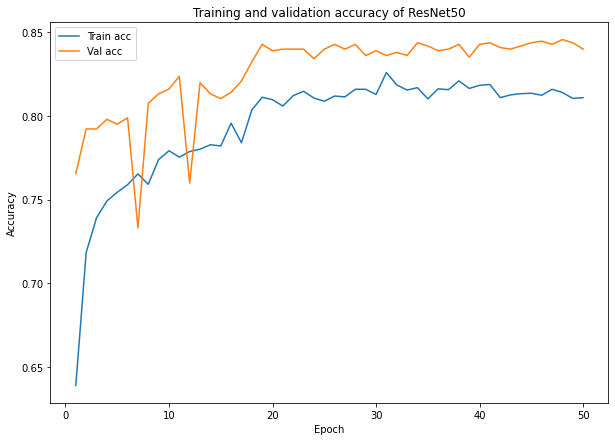

In [ ]:
import matplotlib.pyplot as plt
import json

epochs = [x + 1 for x in range(50)]
train_acc, val_acc = [], []
for epoch in epochs:
    train_acc.append(history['all_epoch_info'][epoch - 1]['info']['train']['acc'])
    val_acc.append(history['all_epoch_info'][epoch - 1]['info']['val']['acc'])

plt.figure(figsize=(10, 7))
plt.plot(epochs, train_acc, label='Train acc')
plt.plot(epochs, val_acc, label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy of ResNet50')
plt.legend()
plt.plot()
plt.savefig('train-resnet.pdf')